Title: RP- Spatial Accessibility of COVID-19 Healthcare Resources in Illinois Pre-Processing Script
---

This is a script that automates as much of the data gathering and pre-processing as possible for reproduction of Kang et al. (2020).

**Reproduction of**: Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA

Original study *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x).

Script Authors: Derrick Burt and Joseph Holler

Reproduction Materials Available at: [RP-Kang Repository](https://github.com/HEGSRR/RPr-Kang-2020)

Created: `29 Jun 2021`
Revised: `23 Aug 2021`

### Modules
Import necessary libraries to run this model.
See `requirements.txt` for the library versions used for this analysis.

In [1]:
# Load modules
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium
import itertools
import os
import time
import warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")

## Check Directories

Because we have restructured the repository for replication, we need to check our working directory and make necessary adjustments.

In [2]:
os.getcwd()

'/home/jovyan/work/RPr-Kang-2020/procedure/code'

In [3]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
    
os.getcwd()

'/home/jovyan/work/RPr-Kang-2020'

### Load Chicago Shapfile and Create Hexagon Grids (500-meter resolution)

Could not pre-process this step because there is no clear-cut way to construct hex grids from a .gdf with python.

The Chicago 'Place' shapfile can be accessed from:
ftp://ftp2.census.gov/geo/tiger//TIGER2020/PLACE/tl_2020_17_place.zip

with the following code:

```py
# Download Illinous plac tract shapefiles to data/raw/public/Pre-Processing/ for All of Illinious (017)
if not os.path.exists('data/raw/public/Pre-Processing/tl_2020_17_place.zip'):
    !wget -P data/raw/public/Pre-Processing/ ftp://ftp2.census.gov/geo/tiger//TIGER2020/PLACE/tl_2020_17_place.zip
    # Extract shapefiles
    !unzip -d data/raw/public/Pre-Processing/ data/raw/public/Pre-Processing/tl_2020_17_place.zip
    # Read in all place shapefiles for Illinois
    place_shp = gpd.read_file('data/raw/public/Pre-Processing/tl_2020_17_place.shp')
    # Select only Chicago
    chicago_shp = place_shp.loc[place_shp['NAME']=='Chicago']
    # Save as shapefile
    chicago_shp.to_file('data/raw/public/Pre-Processing/chicago_place.shp')
else:
    # Read in all census tracts for Illinois
    chicago_shp = gpd.read_file('data/raw/public/Pre-Processing/chicago_place.shp')
```

<AxesSubplot:>

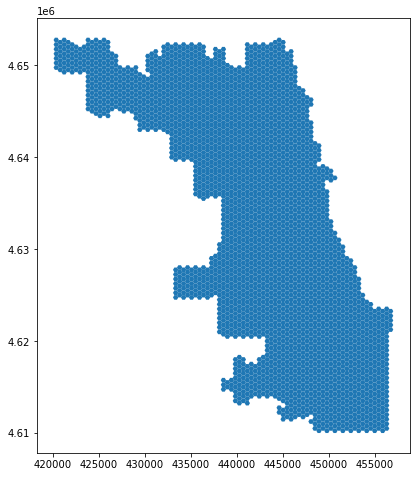

In [4]:
# Read in and plot grid file for Chicago
grid_file = gpd.read_file('./data/raw/public/GridFile/Chicago_Grid.shp')
grid_file.plot(figsize=(8,8))

### Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.
 
We could not automate the pre-processing steps for the hospital data because of ambiguous documentation of the sources:

The paper lists IDPH as a source for ventilators and icu beds, but the site only makes IDPH data publicly available at the state summary level.

We were able to get hospital data from:
https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.geojson

And ICU bed data from:
https://healthdata.gov/resource/uqq2-txqb.json

With the following code:
```py
# ADD CODE TO SAFE INTO RAW DATA FOLDER
# Set file paths for general care and icu beds
fp_gen = 'https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.geojson'
fp_icu = 'https://healthdata.gov/resource/uqq2-txqb.json'

# Eequests for g eneral care and icu beds
r_gen = requests.get(fp_gen)
r_icu = requests.get(fp_icu)

# Get hospitals 
hospitals_gen = gpd.GeoDataFrame.from_features(geojson.loads(r_gen.content),  crs="EPSG:26971")
hospitals_icu = pd.DataFrame.from_dict(json.loads(r_icu.content))

# # Filter for icu and general care
hospitals_gen = hospitals_gen.loc[(hospitals_gen['STATE'] == 'IL') & (hospitals_gen['TYPE'] == 'GENERAL ACUTE CARE')]
# ERROR Here: it is only taking the first thousand
hospitals_icu = hospitals_icu[['hospital_pk', 'collection_week', 'state', 'city', 'ccn', 'hospital_name', 'zip', 'ccn', 'address', 'total_icu_beds_7_day_avg']]

# Capitalize join column 
hospitals_icu.rename(columns={'address':'ADDRESS'}, inplace=True)

# Join
hospitals_api = hospitals_gen.merge(hospitals_icu, on='ADDRESS')

# Check 
hospitals_icu['city'].unique()
```

But could not incorporate it into the notebook as we could not find ventilator data

In [5]:
# read in hospital data
hospitals = gpd.read_file('./data/raw/public/HospitalData/Chicago_Hospital_Info.shp')
hospitals.head()

,FID,Hospital,City,ZIP_Code,X,Y,Total_Bed,Adult ICU,Total Vent,geometry
0,2,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,36,12,MULTIPOINT (-87.67108 41.97280)
1,4,Advocate Christ Medical Center,Oak Lawn,60453,-87.732483,41.720281,785,196,64,MULTIPOINT (-87.73248 41.72028)
2,13,Evanston Hospital,Evanston,60201,-87.683288,42.065393,354,89,29,MULTIPOINT (-87.68329 42.06539)
3,24,AMITA Health Adventist Medical Center Hinsdale,Hinsdale,60521,-87.920116,41.805613,261,65,21,MULTIPOINT (-87.92012 41.80561)
4,25,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,66,21,MULTIPOINT (-87.69084 41.77000)


### Pre-processing: 

all of the pre-processing steps are provided in the code below. However, the code set up to only grab those files from the source if they do not already exist. All of the pre-processd data in the below steps were gathered and saved to the repository on July 15, 2021.

### Automate/Pre-Process Census Data  with API

*Note* you will need to download a new module called 'censusdata'

To do this, open a terminal in the cybergisx environment and type:

```pip install censusdata```

**Note: we deviate from the original paper's methodology here bringing in a larger buffer distance of census tracts

#### Tract

In [6]:
# Load module
import censusdata as cd

ModuleNotFoundError: No module named 'censusdata'

In [ ]:
if not os.path.exists("data/raw/public/Pre-Processing/overfifty_tracts_preprocessed.csv"):
    # Read in all Illinois tracts using census API
    pop_api = cd.download('acs5', 2018,
                                 cd.censusgeo([('state', '17'), ('tract', '*')]),
                                     ['B01001_001E', 'B01001_016E', 'B01001_017E', 'B01001_018E', 'B01001_019E', 
                                      'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 
                                      'B01001_025E', 'B01001_040E', 'B01001_041E', 'B01001_042E', 'B01001_043E', 
                                      'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E',
                                      'B01001_049E'])
    ## Reformat and Rename columns
    # Sum + Rename 50+ population
    pop_api['OverFifty'] = pop_api.iloc[:, 1:21].sum(axis=1)

    # Rename Total Pop column
    pop_api['TotalPop'] = pop_api['B01001_001E']
    
    # Drop irrelevant columns
    pop_api = pop_api.drop(pop_api.columns[0:21], axis=1)
    
    # Create column from index tract # -- we will need thee tract ID for a join
    pop_api['TRACTCE'] = pop_api.index

    # Convert to string 
    pop_api['TRACTCE'] = pop_api['TRACTCE'].astype(str)

    # Slice last 6 digits (tract id)
    pop_api['TRACTCE'] = pop_api['TRACTCE'].str.slice(-6)

    # IF running the first time and path does not exist, uncommnt below to save:
    #pop_api.to_csv("data/raw/public/Pre-Processing/overfifty_tracts_preprocessed.csv", sep=',')

else:
    pop_api = pd.read_csv("data/raw/public/Pre-Processing/overfifty_tracts_preprocessed.csv",
                         dtype={'Unnamed:0':str,'OverFifty':np.int64,'TotalPop':np.int64,'TRACTCE':str})

pop_api.head()

#### Zip Codes

In [ ]:
if not os.path.exists("data/raw/public/Pre-Processing/population_zip_preprocessed.csv"):
    # Read in all Illinois tracts using census API
    zip_api = cd.download('acs5', 2019,
                                 cd.censusgeo([('state', '17'), ('zip code tabulation area', '*')]),
                                              ['B01003_001E'])
    
    # rename population column
    pop_col = {"B01003_001E":"pop"}
    zip_api = zip_api.rename(columns=pop_col)
    
    # Create column from index tract # -- we will need thee tract ID for a join
    zip_api['ZCTA5CE10'] = zip_api.index
    
    # Convert to string 
    zip_api['ZCTA5CE10'] = zip_api['ZCTA5CE10'].astype(str)
    
    # Slice last 6 digits (tract id)
    zip_api['ZCTA5CE10'] = zip_api['ZCTA5CE10'].str.slice(6,11)
    
    # IF running the first time and path does not exist, uncommnt below to save:
    #zip_api.to_csv("data/raw/public/Pre-Processing/population_zip_preprocessed.csv", sep=',')

else:
    zip_api = pd.read_csv("data/raw/public/Pre-Processing/population_zip_preprocessed.csv",
                         dtype={'Unnamed:0':str,'pop':np.int64,'ZCTA5CE10':str})
    
zip_api.head()

### Automate/Pre-Process COVID-19 with Requests

Download covid data that will be kjoined to zip code geographies.

In [ ]:
import requests
import geojson
import json

In [ ]:
if not os.path.exists("data/raw/public/Pre-Processing/covidcases_zip_preprocessed.csv"):
    # Unfortunately... I have not found how to access archived COVID-119 case data, so this data is cases from 4/6/2021 - 6/30/2021 (or current date...) 
    # Set file path
    fp_covid = 'https://idph.illinois.gov/DPHPublicInformation/api/COVIDExport/GetZip'

    # Make reqeuest
    r_covid = requests.get(fp_covid)

    # Save request as dataframe
    covid_cases = pd.DataFrame.from_dict(json.loads(r_covid.content))

    # Change confirmed cases to cases
    cases_col = {'zip':"ZCTA5CE10", "confirmed_cases":"cases"}
    covid_cases = covid_cases.rename(columns=cases_col)
    
    # Merge covid case data with zip code population to normalize cases
    covid_api = covid_cases.merge(zip_api, how="inner", on="ZCTA5CE10")
    
    # IF running the first time and path does not exist, uncomment below to save:
    #covid_api.to_csv("data/raw/public/Pre-Processing/covidcases_zip_preprocessed.csv", sep=',')
    
else:
    covid_api = pd.read_csv("data/raw/public/Pre-Processing/covidcases_zip_preprocessed.csv",
                           dtype={'reportdat':str,'ZCTA5CE10':str,'case':np.int64,'total_testd':np.int64,'pop':np.int64})
    
covid_api.head()

### Pull Census Boundary Shapefiles with FTP Site and Join to Population/Covid Case Data

#### Note: Here, we extract *census tracts* and *zip code geographies* based on their spatial relationship (intersection) with the street network

Census TIGER/Line shapefiles can bee accessed from ftp://ftp2.census.gov/geo/tiger/ using !wget

File path for Cook County 2010 tracts: ftp://ftp2.census.gov/geo/tiger//TIGER2010/TRACT/2010/tl_2010_17031_tract10.zip

File path for Illinois 2010 tracts: ftp://ftp2.census.gov/geo/tiger//TIGER2018/TRACT/tl_2018_17_tract.zip

#### Tracts

In [ ]:
# Check directory -- we want to downlaod the raw data directly into our pre-processing data folder
%ls

In [ ]:
# Download census tract shapefiles to data/raw/public/Pre-Processing/ for All of Chicago (017)
if not os.path.exists('data/raw/public/Pre-Processing/tl_2018_17_tract.zip'):
    !wget -P data/raw/public/Pre-Processing/ ftp://ftp2.census.gov/geo/tiger//TIGER2018/TRACT/tl_2018_17_tract.zip
    # Extract shapefiles
    !unzip -d data/raw/public/Pre-Processing/ data/raw/public/Pre-Processing/tl_2018_17_tract.zip
    # Read in all census tracts for Illinois
    tracts_shp = gpd.read_file('data/raw/public/Pre-Processing/tl_2018_17_tract.shp')
else:
    # Read in all census tracts for Illinois
    tracts_shp = gpd.read_file('data/raw/public/Pre-Processing/tl_2018_17_tract.shp')

In [ ]:
# Set crs to WGS 84
tracts_shp = tracts_shp.to_crs(epsg=4326)

# Select only tracts from Cook countiy + its adjacent counties
tracts_shp = tracts_shp.loc[(tracts_shp["COUNTYFP"] == '031') |
                            (tracts_shp["COUNTYFP"] == '043') |
                            (tracts_shp["COUNTYFP"] == '097') |
                            (tracts_shp["COUNTYFP"] == '197') ]

# Check crs
print(tracts_shp.crs)

# Check length
print(len(tracts_shp))

# Check column names
tracts_shp.head()

In [ ]:
# Rename columns for join
new_names = {"GEOID10":"GEOID", "TRACTCE10":"TRACTCE"}
tracts_shp = tracts_shp.rename(columns=new_names)

In [ ]:
# Join Tracts shape with Tracts Population data
## This drops duplicate values so that we do not end up with
atrisk_data = tracts_shp.merge(pop_api.drop_duplicates(subset=['TRACTCE']), how='inner', on="TRACTCE")
atrisk_data= atrisk_data.drop(atrisk_data.columns[5:10], axis=1)
len(atrisk_data)

In [ ]:
atrisk_data.head()

##### Zip codes

In [ ]:
# check directory -- we want to downlaod the raw tract data directly into our data folder
%ls

In [ ]:
# Download zip code shapefiles to data/raw/public/Pre-Processing/ for entire US
## I have not yet found a way to select by state before extracting
if not os.path.exists('data/raw/public/Pre-Processing/cb_2018_us_zcta510_500k.zip'):
    !wget -P data/raw/public/Pre-Processing/ ftp://ftp2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_zcta510_500k.zip
    # Extract shapefiles
    !unzip -d data/raw/public/Pre-Processing/ data/raw/public/Pre-Processing/cb_2018_us_zcta510_500k.zip
    # read in zip code data
    usa_zip = gpd.read_file('data/raw/public/Pre-Processing/cb_2018_us_zcta510_500k.shp')
else:
    # read in zip code data
    usa_zip = gpd.read_file('data/raw/public/Pre-Processing/cb_2018_us_zcta510_500k.shp')

In [ ]:
# Select only Illinois
ill_zip = usa_zip.loc[(usa_zip['GEOID10'] >= '60002') & (usa_zip['GEOID10'] <= '60827')]

# Set crs to WGS 84
ill_zip = ill_zip.to_crs(epsg=4326)

# Check crs
print(ill_zip.crs)

# Check length
print(len(ill_zip))

# Rename column names
ill_zip.head()

In [ ]:
# Join covid_zip to zip code geographies 
covid_data = ill_zip.merge(covid_api, how='inner', on='ZCTA5CE10')
# Drop extra columns
# covid_zip_geo = covid_zip_geo.drop(covid_zip_geo.columns[5:10], axis=1)
print(len(covid_data))
covid_data.head()

##### Export Final Shapefiles

In [ ]:
# Set file paths
covid_fp = 'data/raw/public/Pre-Processing/covid_pre-processed.shp'
atrisk_fp = 'data/raw/public/Pre-Processing/atrisk_pre-processed.shp'

# Export
covid_data.to_file(covid_fp)
atrisk_data.to_file(atrisk_fp)